### Project Report Group 12

Great project and a great proposal layout. I also appreciate ensuring the code is reproducible. Some feedback regarding the different components:

Throughout the project, make sure you back up any claims you make (ex. heart disease is the greatest killer in the world) using trusted sources.

When conducting your exploratory analysis, I recommend avoiding standardizing your variables. Scaling/centering is necessary when you're building a KNN model with multiple variables. For exploratory analysis, your data loses interpretability once you scale/center.

For your graphs, I suggest using boxplots to compare variables in a more obvious manner. While scatter plots are prettier to look at, they can sometimes be less informative/confusing to interpret. Reach out if you have any questions about building/reading boxplots (geom_boxplot). Besides that, I appreciate the visualizations you created. While the histograms are useful, I recommend setting position = "identity" and not faceting the plot (unless you're putting one over the other). This allows you to compare the peak/center between individuals with/without heart disease. 

Again, i recommend not scaling the data at this stage. Also, in your final report, please make sure you spend more time interpreting your graphs in commentary. For example: "The distribution of ages of individuals diagnosed with heart disease is shifted to the right relative to those with no heart disease (i.e. they're older). Based on this, I believe age is a good predictor for heart disease."

In your methods, make sure you address how you plan on defining the best value of K. Great job with the rest of the methods section.

# Title: Heart Disease Prediction

# Legend
Figures:
- Figure 1: Predictor Histograms
- Figure 2: Predictor box plots
- Figure 3: Neighbors vs Accuracy plot

Tables:
- Table 1: All data table
- Table 2: Relevant data table
- Table 3: Heart disease count table
- Table 4: Mean of predictor variables table
- Table 5: Accurcy table and confusion matrix

# Introduction:

**Background Information**
<br>
Heart diseases are a specific group of cardiovascular diseases that refer to conditions specifically affecting the behaviour or structure of the heart. These types of diseases are the leading cause of death across the world (Cardiovascular Diseases, 2019) which explains why diagnosis at an early stage is important so that patients can get immediate treatment. Multiple underlying health conditions and lifestyle choices can increase the likelihood of heart diseases, such as diabetes, and high blood pressure. Some possible symptoms of heart disease are heart attacks, and strokes.

**Our Question:**
<br>
How accurately can we identify whether or not a patient has heart disease based on their age, resting blood pressure, and cholesterol level?

**Our Dataset:**
<br>
Our dataset is called "Heart Failure Prediction Dataset" and was obtained from kaggle (Heart Failure Prediction Dataset, 2021). It includes 11 clinical features for predicting heart disease and is a combination of 5 smaller datasets including the Cleveland, Hungarian, Switzerland, Stalog (Heart) Data Set, and Long Beach VA datasets all originally sourced from the UCI Machine Learning Repository. It contains information on health factors of patients and whether or not these patients had heart disease.

# Methods & Results:

### Import necessary libraries

In [1]:
# import needed libraries
library(tidyverse)
library(repr)
library(tidymodels)
library(gridExtra)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

#### Load data from source on the web 

Kaggle page for dataset: https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction

In [2]:
# read dataset from web
heart <- read_csv("https://raw.githubusercontent.com/josephsoo/dsci_100_group_12/main/data/heart.csv")


Rows: 918 Columns: 12
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (5): Sex, ChestPainType, RestingECG, ExerciseAngina, ST_Slope
dbl (7): Age, RestingBP, Cholesterol, FastingBS, MaxHR, Oldpeak, HeartDisease

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


#### Wrangle and clean the data

Below we wrangle and clean the data by turning the HeartDisease column into a factor type and removing the rows
where cholesterol = 0.

Note: HeartDisease = 0 means the person *does not* have heart disease. HeartDisease = 1 means the person *does* have it.

In [3]:
# clean and wrangle into tidy format
# by turning HeartDisease in a factor type and 
# removing rows where cholesterol = 0
heart_clean <- mutate(heart, HeartDisease = as_factor(HeartDisease)) |> filter(Cholesterol != 0)
head(heart_clean)


Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<fct>
40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0
39,M,NAP,120,339,0,Normal,170,N,0.0,Up,0


Table 1: All data table

We will be using 3 predictors: Cholesterol, Resting BP (blood pressure), and Age. Therefore, we will only select the releveant columns. More reasons as to why we chose these 3 can be found later on in the report. WHY CHOOSE THESE 3. Literature approach or summary of data. also test other variables.

In [4]:
heart_clean <- select(heart_clean, Age, RestingBP, Cholesterol, HeartDisease)
head(heart_clean)

Age,RestingBP,Cholesterol,HeartDisease
<dbl>,<dbl>,<dbl>,<fct>
40,140,289,0
49,160,180,1
37,130,283,0
48,138,214,1
54,150,195,0
39,120,339,0


Table 2: Relevant data table

#### Split the data

We will now split the data into training and testing sets. 75% of the data will be used for training and 25% will be used for testing.

We have also set the seed to allow for reproducible results.

In [5]:
set.seed(3456) 

# splitting data 75% = training, 25% = testing
heart_split <- initial_split(heart_clean, prop = 0.75, strata = HeartDisease)  
heart_train <- training(heart_split)   
heart_test <- testing(heart_split)

### Creating tables to summarize the training data

We have made tables showing the number of observations in each class and showing the mean of each predictor to analyze/summarize the data.

In [6]:
# number of observations in each class of heart disease
heart_disease_count <- heart_train |> group_by(HeartDisease) |> summarize(n = n())
heart_disease_count

HeartDisease,n
<fct>,<int>
0,292
1,267


Table 3: Heart disease count table

We can see from table 3 that the split between people with and without heart disease is generally pretty even (52% of data is people without, and 48% is people with). Thus, we deem it unnessecary to balance the dataset.

In [7]:
# averages of each predictor variable
predictor_means <- heart_train |> select(-HeartDisease) |> map_df(mean)
colnames(predictor_means) <- c("Age_mean", "RestingBP_mean", "Cholesterol_mean")
predictor_means

Age_mean,RestingBP_mean,Cholesterol_mean
<dbl>,<dbl>,<dbl>
53.23077,133.5063,244.6869


Table 4: Mean of predictor variables table -> group by heart disease and compare to general/literatrue values

The KNN model is sensitive to the scale of the data, so, if we were to not standardize our data, larger scaled predictors would be considered more strongly, when we want to consider them around equally. As we can see from table 3, cholesterol has a much larger scale than age. As a result, we can see that when we run our KNN classification, we should standardize the data.

## Creating data visualizations of the training data



#### Histograms

Overall, we can see an underlying trend where the people with no heart disease lie on the left side of these histograms (low age, resting bp, and cholesterol), while the people with heart disease lie on the right side.

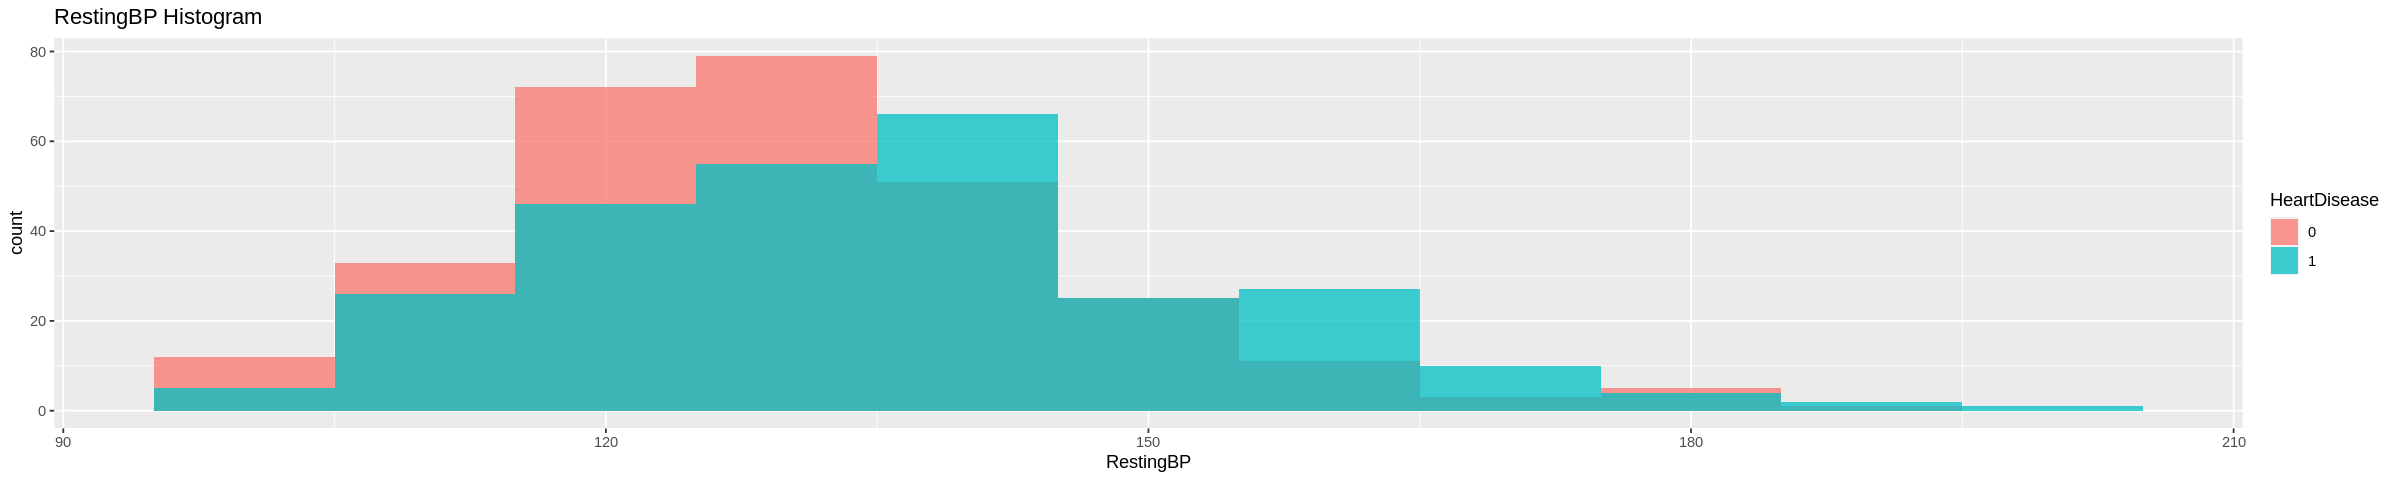

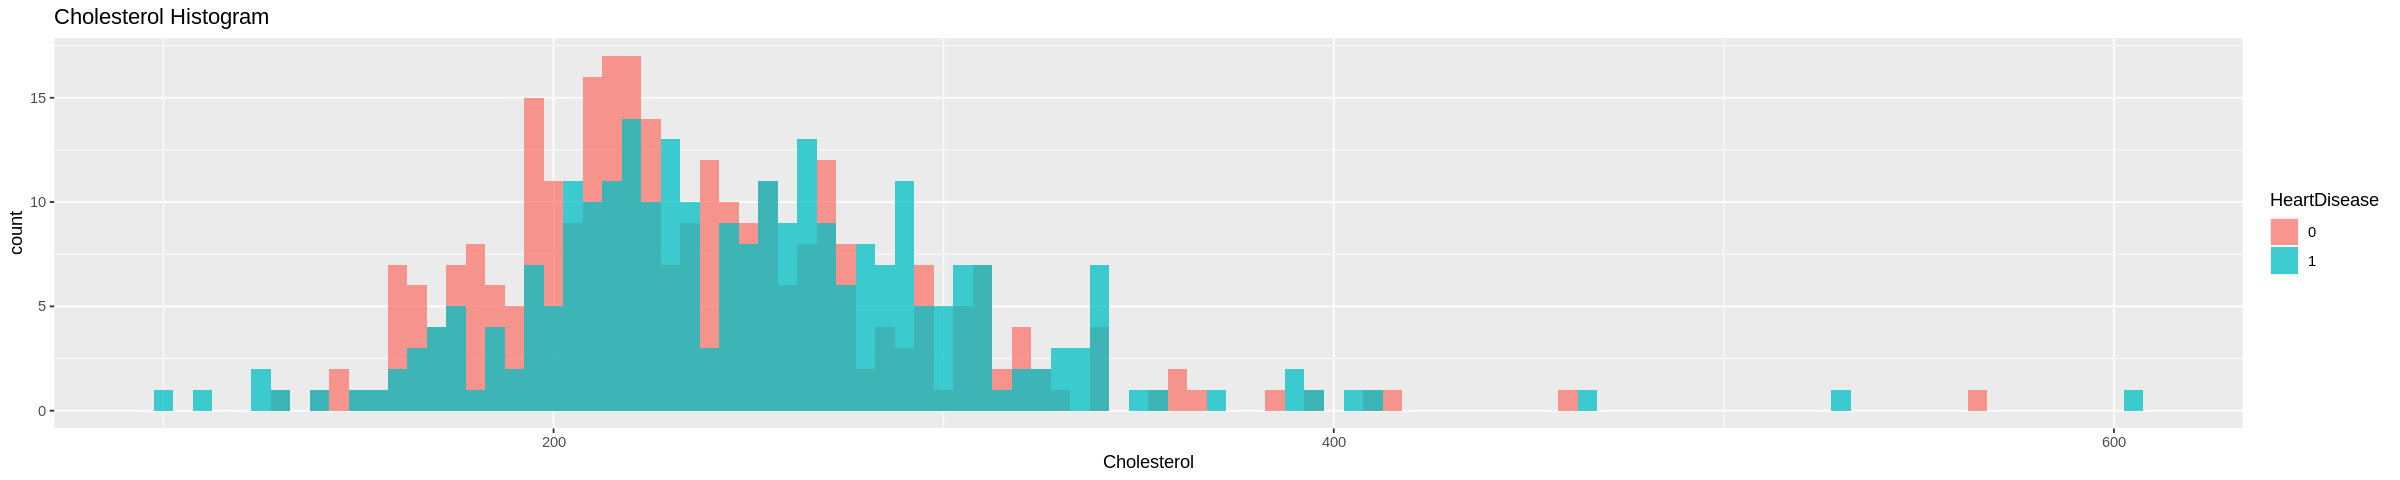

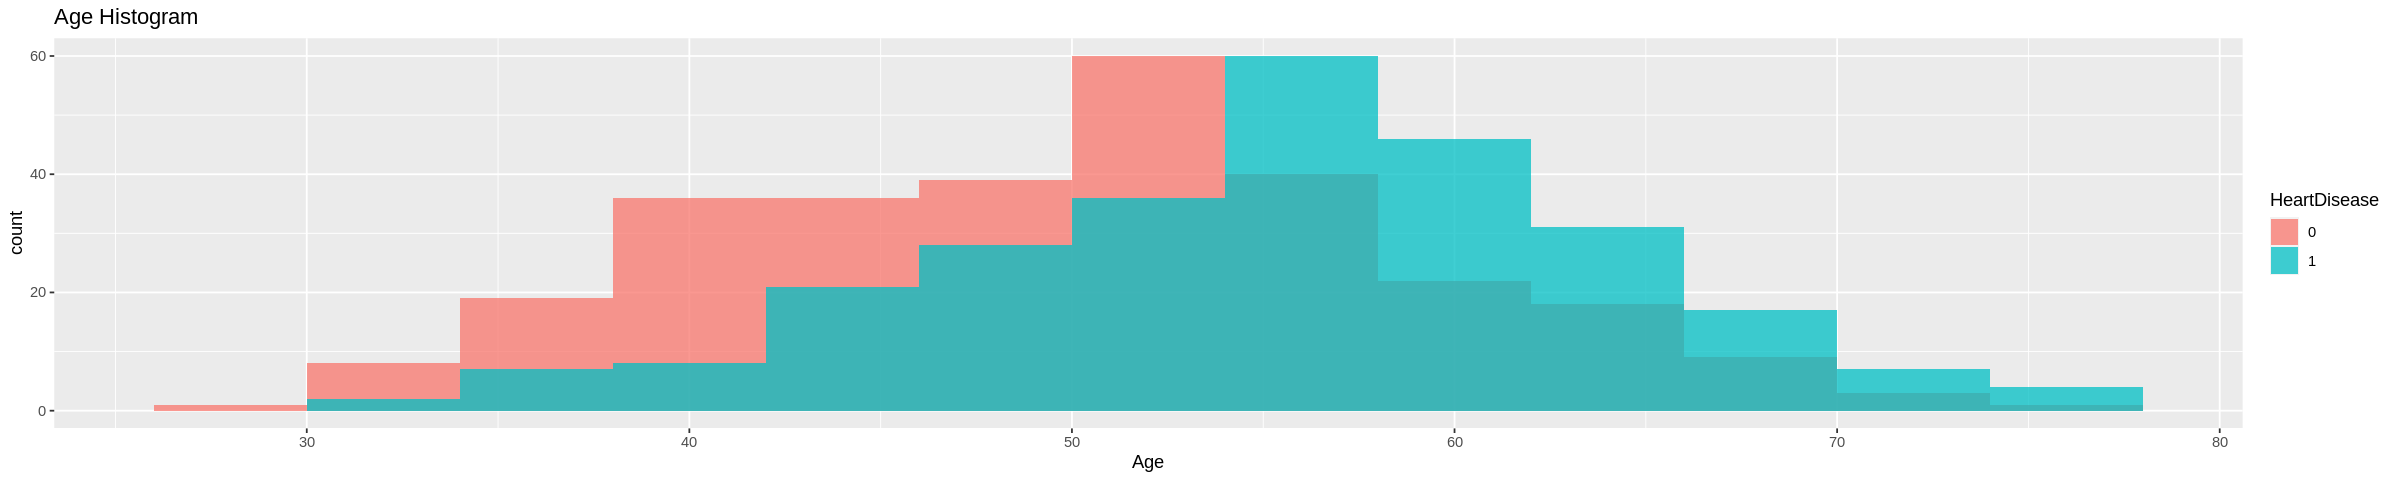

In [20]:
options(repr.plot.width = 20, repr.plot.height = 4)

bp_histo <- heart_train |> ggplot(aes(x = RestingBP, fill = HeartDisease)) +
    geom_histogram(position = "identity", binwidth = 10, alpha = 0.75) +
    labs(title = "RestingBP Histogram")

cholesterol_histo <- heart_train |> ggplot(aes(x = Cholesterol, fill = HeartDisease)) +
    geom_histogram(position = "identity", binwidth = 5, alpha = 0.75) +
    labs(title = "Cholesterol Histogram")


age_histo <- heart_train |> ggplot(aes(x = Age, fill = HeartDisease)) +
    geom_histogram(position = "identity", binwidth = 4, alpha = 0.75) +
    labs(title = "Age Histogram")



bp_histo
cholesterol_histo
age_histo

Figure 1: Predictor Histograms

#### Box plots

The findings found with histrograms are reinforced by the boxplots. As we can see in the boxplots, the mean of the variables for people with heart disease is higher than those without. Of the boxplots, we can see that age has the least overlap in standard deviations, which may indicate that age is a very strong predictor for heart. put box plot under histogram for each variable and go var by var

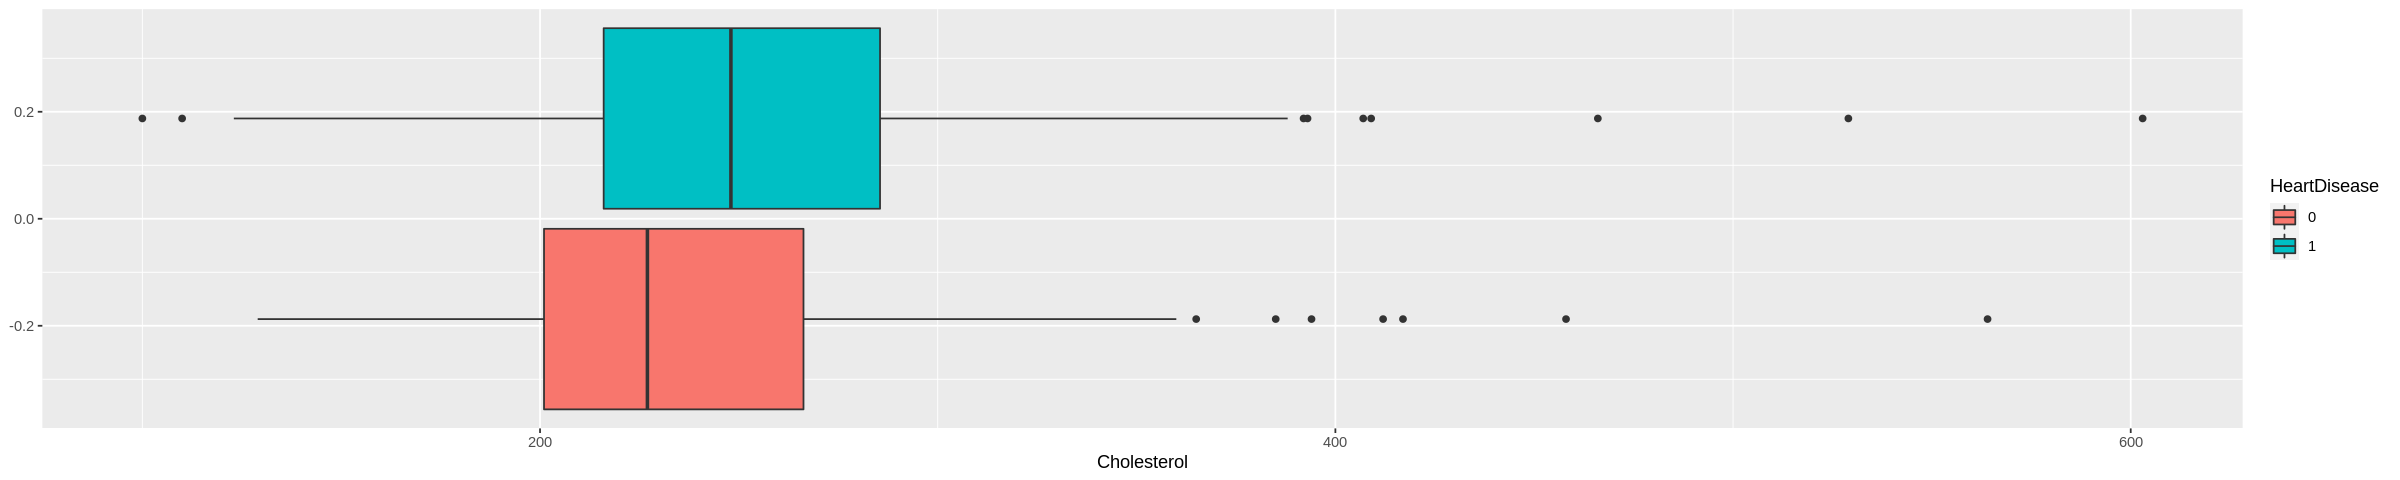

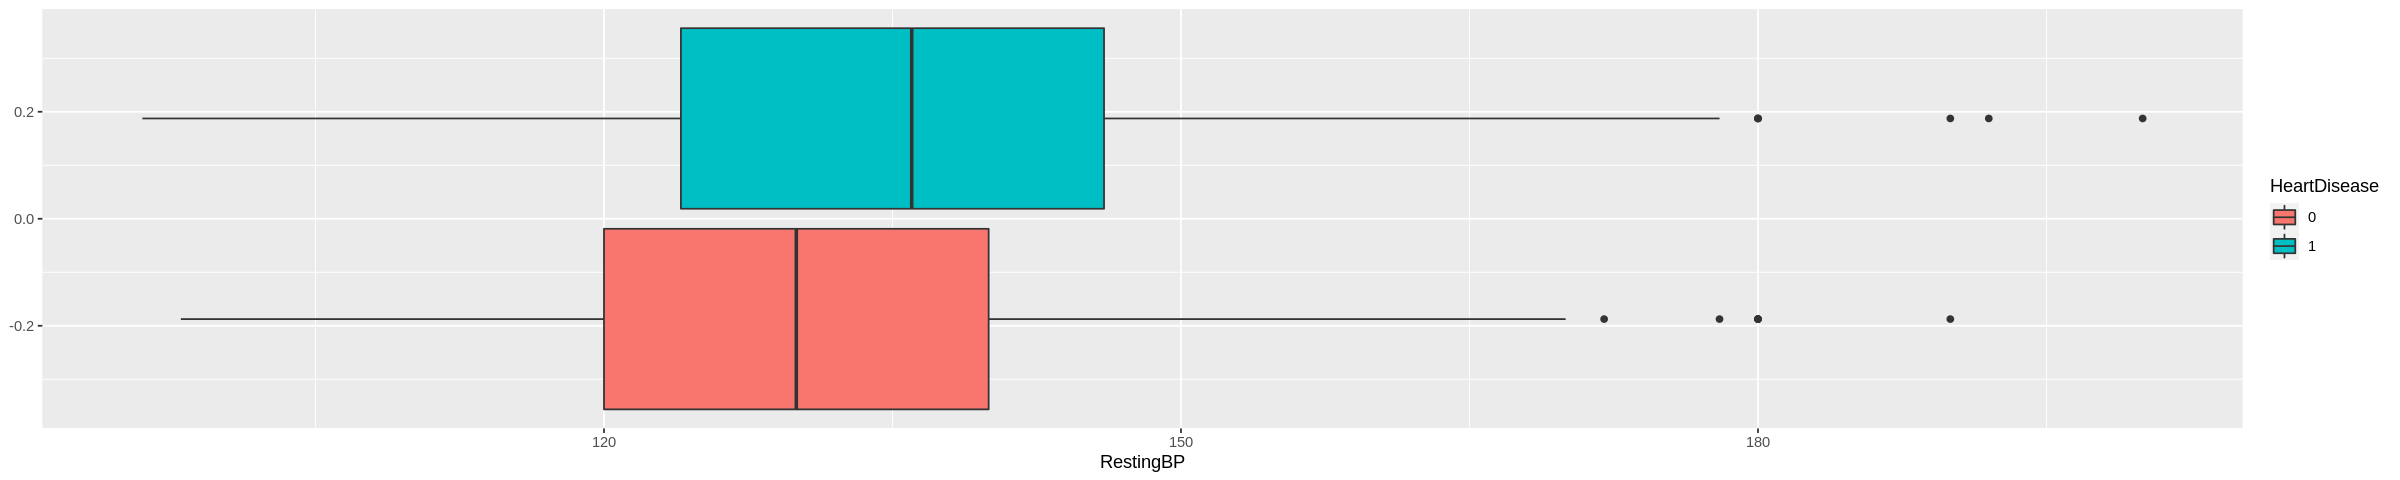

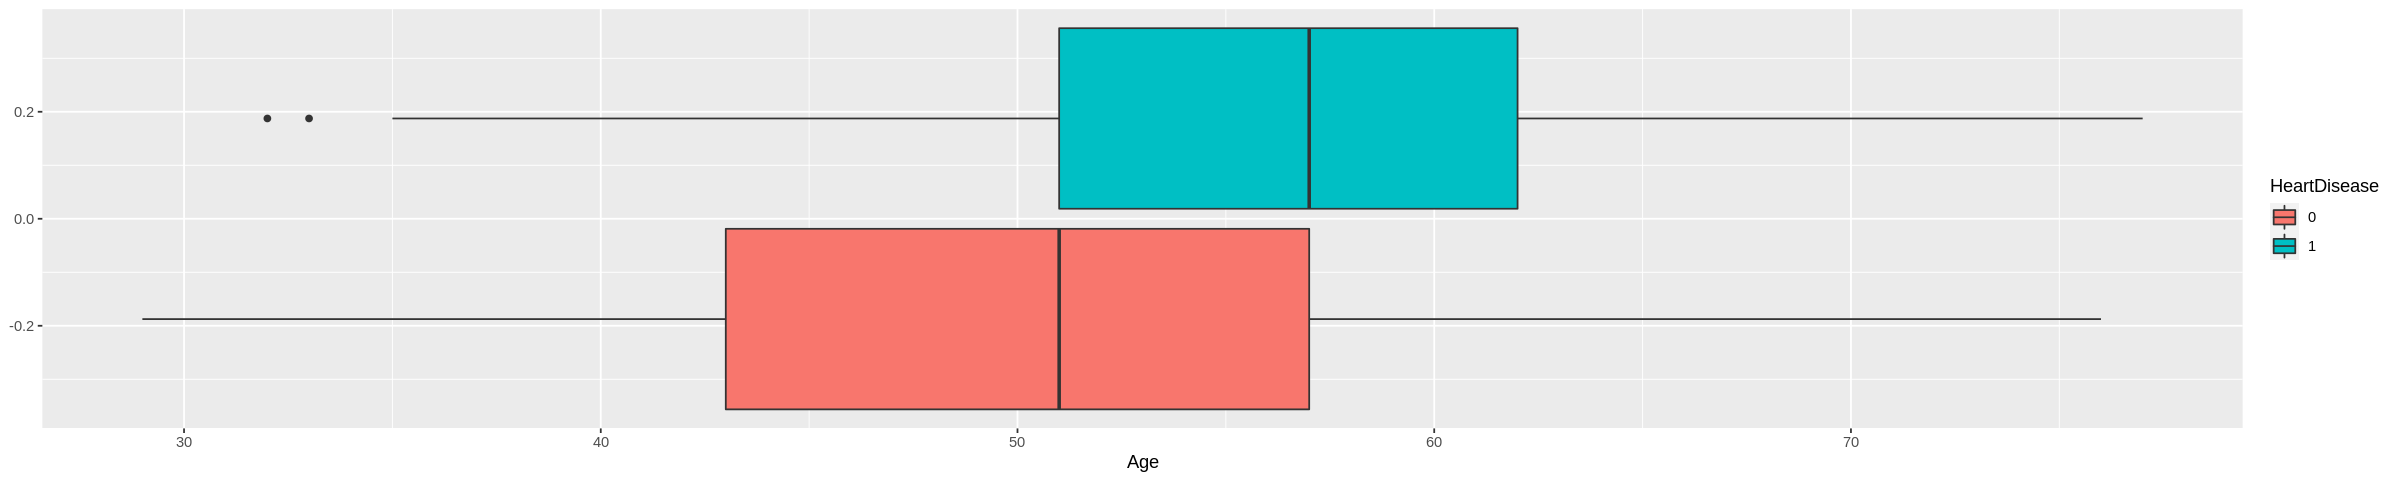

In [9]:
cholesterol_box <- heart_train |> ggplot(aes(x = Cholesterol, fill = HeartDisease)) +
    geom_boxplot()


bp_box <- heart_train |> ggplot(aes(x = RestingBP, fill = HeartDisease)) +
    geom_boxplot() 

age_box <- heart_train |> ggplot(aes(x = Age, fill = HeartDisease)) +
    geom_boxplot()

cholesterol_box
bp_box
age_box

Figure 2: Predictor box plots

### Choosing a Combination of Predictor Variables Through Forward Selection

Before we begin the construction of the prediction model, we want to see what combination of predictor variables will result in the highest prediction accuracy. We have selected variables we think are relevant to the prediction model, but it may be a the case that some of them are actually not. To determine the combination of predictor variables, we will use forward selection which the process of iteratively building up a model and determining its accuracy by adding one predictor variable at a time (Timbers, 2022). Do with all variables.

In [15]:
set.seed(3456) 

heart_scaled <- heart_train |>
    mutate(scaled_Cholesterol = scale(Cholesterol, center = TRUE),
        scaled_RestingBP = scale(RestingBP, center = TRUE),
        scaled_Age = scale(Age, center = TRUE))|>
    select(HeartDisease, scaled_Cholesterol, scaled_RestingBP, scaled_Age)

heart_subset <- heart_scaled |>
    select(HeartDisease,
           scaled_Age,
           scaled_Cholesterol,
           scaled_RestingBP)
names <- colnames(heart_subset |> select(-HeartDisease))
#heart_subset

formula <- paste("HeartDisease", "~", paste(names, collapse="+"))
#formula

# create an empty tibble to store the results
accuracies <- tibble(size = integer(), 
                     model_string = character(), 
                     accuracy = numeric())

# create a model specification
knn_spec <- nearest_neighbor(weight_func = "rectangular", 
                             neighbors = tune()) |>
     set_engine("kknn") |>
     set_mode("classification")

# create a 5-fold cross-validation object
heart_vfold <- vfold_cv(heart_subset, v = 5, strata = HeartDisease)

# store the total number of predictors
n_total <- length(names)

# stores selected predictors
selected <- c()

# for every size from 1 to the total number of predictors
for (i in 1:n_total) {
    # for every predictor still not added yet
    accs <- list()
    models <- list()
    for (j in 1:length(names)) {
        # create a model string for this combination of predictors
        preds_new <- c(selected, names[[j]])
        model_string <- paste("HeartDisease", "~", paste(preds_new, collapse="+"))

        # create a recipe from the model string
        heart_recipe <- recipe(as.formula(model_string), 
                                data = heart_subset) |>
                          step_scale(all_predictors()) |>
                          step_center(all_predictors())

        # tune the KNN classifier with these predictors, 
        # and collect the accuracy for the best K
        acc <- workflow() |>
          add_recipe(heart_recipe) |>
          add_model(knn_spec) |>
          tune_grid(resamples = heart_vfold, grid = 10) |>
          collect_metrics() |>
          filter(.metric == "accuracy") |>
          summarize(mx = max(mean))
        acc <- acc$mx |> unlist()

        # add this result to the dataframe
        accs[[j]] <- acc
        models[[j]] <- model_string
    }
    jstar <- which.max(unlist(accs))
    accuracies <- accuracies |> 
      add_row(size = i, 
              model_string = models[[jstar]], 
              accuracy = accs[[jstar]])
    selected <- c(selected, names[[jstar]])
    names <- names[-jstar]
}
accuracies

size,model_string,accuracy
<int>,<chr>,<dbl>
1,HeartDisease ~ scaled_Age,0.5849797
2,HeartDisease ~ scaled_Age+scaled_Cholesterol,0.6227218
3,HeartDisease ~ scaled_Age+scaled_Cholesterol+scaled_RestingBP,0.6369449


## Predictions:

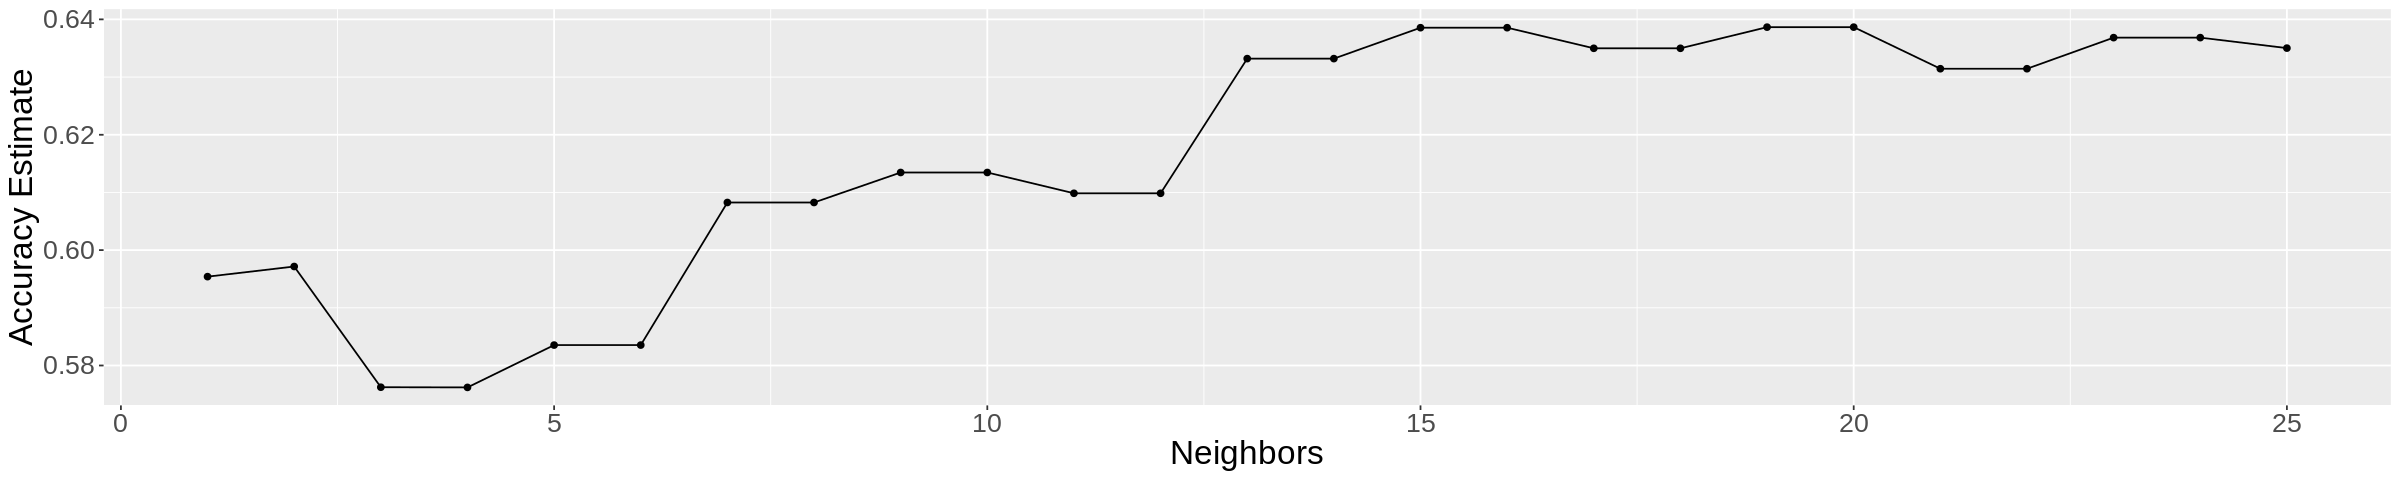

In [16]:
set.seed(3456) 
heart_vfold <- vfold_cv(heart_train, v = 10, strata = HeartDisease)

##(3)##
heart_recipe <- recipe(HeartDisease ~ Cholesterol + RestingBP + Age, data = heart_train) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

##(4)##
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")

gridvals <- tibble(neighbors = seq(1, 25))


knn_results <- workflow() |>
  add_recipe(heart_recipe) |>
  add_model(knn_spec) |>
  tune_grid(resamples = heart_vfold, grid = gridvals) |>
  collect_metrics() |>
  filter(.metric == "accuracy")

# Plotting k values against their respective accuracies and choose optimal k value
cross_val_plot <- knn_results |> 
    ggplot(aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "Neighbors", y = "Accuracy Estimate") +
    theme(text = element_text(size = 20))

cross_val_plot

Figure 3: Neighbors vs Accuracy plot

As we can see from the above accuracy vs neigbors plot, k = 15 (15 neighbors) has a very high accuracy. Therefore, we chose to use neighbors = 15

In [17]:
knn_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 15) |>
  set_engine("kknn") |>
  set_mode("classification")

heart_fit <- workflow() |>
  add_recipe(heart_recipe) |>
  add_model(knn_best_spec) |>
  fit(data = heart_train)
  
heart_predictions <- predict(heart_fit, heart_test) |> 
    bind_cols(heart_test)

# Comparing the accuracy of predictions to the data in the test set
heart_acc <- heart_predictions |> 
    metrics(truth = HeartDisease, estimate = .pred_class) |> 
    select(.metric, .estimate) |> 
    head(1)

heart_acc

# Comparing the predictions to the real values in a confusion matrix
heart_cm <- heart_predictions |> 
    conf_mat(truth = HeartDisease, estimate = .pred_class)

heart_cm

.metric,.estimate
<chr>,<dbl>
accuracy,0.6417112


          Truth
Prediction  0  1
         0 74 43
         1 24 46

Table 5: Accurcy table and confusion matrix, spend time on confusion, flase pos/neg important in clinical, convert false pos/n eg to percent, then box plot them for the visualization.

## Discussion:

#### summarize what you found

... During our exploratory analysis, we noticed a few trends between our predictor variables, resting blood pressure, age, cholesterol level, and whether or not the patient had heart disease. Through the usage of box plots and histograms, we concluded that a person would be more likely to have heart disease with greater resting blood pressure, age and cholesterol. We were able to create a classifier using k-nearest neighbors that could diagnose a patient correctly around 60.9% of the time given these 3 predictor variables. A prediction accuracy this low wouldn't be appropriate in a real scenario due to the impact of predicting incorrectly being a potential loss of human life. ...

#### discuss whether this is what you expected to find?
#### discuss what impact could such findings have?
#### discuss what future questions could this lead to?
One question that could be analyzed for future exploration, is seeing what other parameters may serve as better predictors for determining how likely a given patient is to have heart disease. Within the scope of the dataset we analysed, the explored combination of parameters did not achieve the outcome we hoped for when it comes to prediction accuracy. Hence, by exploring other data sets that have more variables for analysis such as VO2 Max, or resting heart rate, we may find that they are more indicative of the likelihood for someone to have heart disease. 

## References

Cardiovascular diseases. (2019, June 11). World Health Organization. https://www.who.int/health-topics/cardiovascular-diseases

Heart Failure Prediction Dataset. (2021, September 10). Kaggle. https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction

Timbers, T. T. C. (2022, September 24). Chapter 6 Classification II: evaluation & tuning | Data Science. https://datasciencebook.ca/classification2.html